In [125]:
!pip install scikit-learn
!pip install spacy
!pip install seaborn
!python -m spacy download en_core_web_sm
!pip install cloudpickle

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib!=3.6.1,>=3.3 from https://files.pythonhosted.org/packages/01/50/0d8d8f044e2a0d8151e9ed59fe50924e9e697ba43a8b12d5ff9b45adb871/matplotlib-3.8.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/87/2b/9b49451f7412cc1a79198e94a771a4e52d65c479aae610b1161c0290ef2c/contourpy-1.1.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/2b/b3/70c33027c4918c10ccf176014b38f8b91cb18ac018a78854543a4fc72609/cycler-0.12.0-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/17/92/ae0f19b89e5d163057757d4a03d1a6949372204e9b0ad2

In [1]:
import pandas as pd
import spacy
import cloudpickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [3]:
data = pd.read_csv('spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


# Обработка датасета
Как видно из содержимого датасета, метки уже имеют удобный, бинарный вид (0 и 1), поэтому тут менять ничего не нужно.
В нашем датасете соотношение "spam" и "not spam" составляет 5 к 1, что не так плохо.
Необходимо проверить, есть ли в датасете пустые значения. Если да, то такие записи необходимо удалить. У нас есть только одна такая запись под индексом 2966.

In [4]:
data['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

In [7]:
pd.isnull(data['email']).values.sum()
n = pd.isnull(data['email'])
data[n]

,email,label


In [6]:
data = data.dropna()

Для обработки текста использовался SpaCy. Были убраны все стоп-слова из списка, цифры, знаки препинания, лишние пробелы. Текст был приведен к нижнему регистру и лемматизирован. Решено было не убирать токены, похожие на email, так как они могут присутствовать в spam сообщениях.

In [8]:
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
data['cleaned_text'] = data['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_space
        and not token.like_num
        and not token.is_punct
        and not token.is_digit
    ))

In [9]:
data['cleaned_text'].sample(7)

838     tuesday number october number number number mr...
2037    url url date number number numbertnumber numbe...
2672    hello zzzz url see nbc cbs cnn oprah health di...
944     robert elz kre munnari oz au date sit number a...
1141    begin pgp sign message hash shanumber content ...
2079    url url date number number numbertnumber numbe...
1513    update cvsroot spamassassin spamassassin t dir...
Name: cleaned_text, dtype: object

In [10]:
cv = 5
metric = 'recall'
random_state = 42

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=random_state)

# CountVectorizer
В данном разделе получим вектора при помощи CountVectorizer; обучим модели: дерево решений, логистическая регрессия и наивный Байес с использованием кросс-валидации и подбором гиперпараметров. 
Для оценки качества использовалась метрика recall, т.к. для данной задачи нам важно понимать, как много мы находим спама. Для подбора гиперпараметров использовался GridSearchCV и HalvingGridSearchCV.

### LogisticRegression:

In [12]:
pipe_log_reg = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('clf', LogisticRegression())
    ]
)

In [19]:
param_grid_log_reg = {
    'counter__max_df': np.linspace(0.3, 0.7, 10),
    'counter__min_df': [0.0, 0.001, 0.003, 0.005],
    'counter__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.linspace(0.1, 1, 10),
}

In [20]:
grid_search_log_reg = GridSearchCV(
    pipe_log_reg,
    param_grid=param_grid_log_reg,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
).fit(x_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [21]:
grid_search_log_reg.best_score_

0.9414385964912281

In [51]:
pred_log_reg = grid_search_log_reg.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_log_reg))
score_log_reg = grid_search_log_reg.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       627
           1       0.99      0.95      0.97       123

    accuracy                           0.99       750
   macro avg       0.99      0.97      0.98       750
weighted avg       0.99      0.99      0.99       750


In [23]:
%%time

grid_search_log_reg_h = HalvingGridSearchCV(
    pipe_log_reg,
    param_grid=param_grid_log_reg,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
    random_state=random_state,
)
grid_search_log_reg_h.fit(x_train, y_train)

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1200
n_resources: 20
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
----------
iter: 1
n_candidates: 400
n_resources: 60
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 2
n_candidates: 134
n_resources: 180
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 3
n_candidates: 45
n_resources: 540
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 4
n_candidates: 15
n_resources: 1620
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 6.31 s
Wall time: 12.8 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=20,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': [(1, 1), (1, 2),
                                                         (1, 3)]},
                    random_state=42, scoring='recall', verbose=1)

In [24]:
grid_search_log_reg_h.best_score_

0.8678656628559036

In [50]:
pred_log_reg_h = grid_search_log_reg_h.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_log_reg_h))
score_log_reg_h = grid_search_log_reg_h.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       627
           1       0.96      0.92      0.94       123

    accuracy                           0.98       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.98      0.98      0.98       750


### DecisionTreeClassifier:

In [26]:
pipe_tree = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('clf', DecisionTreeClassifier())
    ]
)

In [29]:
param_grid_tree = {
    'counter__max_df': np.linspace(0.3, 0.7, 10),
    'counter__min_df': [0.0, 0.001, 0.003, 0.005],
    'counter__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__max_depth': [4, 6, 8],
    'clf__min_samples_split': [2, 6, 10, 14, 18],
    'clf__min_samples_leaf': [2, 6, 10, 14, 18],
}

In [32]:
grid_search_tree = GridSearchCV(
    pipe_tree,
    param_grid=param_grid_tree,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
).fit(x_train, y_train)

Fitting 5 folds for each of 9000 candidates, totalling 45000 fits
CPU times: total: 2min 48s
Wall time: 28min 21s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=20,
             param_grid={'clf__max_depth': [4, 6, 8],
                         'clf__min_samples_leaf': [2, 6, 10, 14, 18],
                         'clf__min_samples_split': [2, 6, 10, 14, 18],
                         'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                         'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                         'counter__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='recall', verbose=1)

In [33]:
grid_search_tree.best_score_

0.8430877192982458

In [52]:
pred_tree = grid_search_tree.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_tree))
score_tree = grid_search_tree.score(x_test, y_test)
modelTree = grid_search_tree

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       627
           1       0.87      0.82      0.85       123

    accuracy                           0.95       750
   macro avg       0.92      0.90      0.91       750
weighted avg       0.95      0.95      0.95       750


Т.к. гиперпараметров довольно много, обучение происходит довольно долго, поэтому было решено сохранить лучшую модель в файл, чтобы не запускать каждый раз обучение и иметь возможность сразу построить графики.

In [35]:
with open('modelTree.pkl', 'wb') as f:
    cloudpickle.dump(modelTree, f)

In [159]:
with open('modelTree.pkl', 'rb') as f:
    modelTree = cloudpickle.load(f)
score_tree = modelTree.score(x_test, y_test)

In [36]:
%%time

grid_search_tree_h = HalvingGridSearchCV(
    pipe_tree,
    param_grid=param_grid_tree,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
    random_state=random_state,
)
grid_search_tree_h.fit(x_train, y_train)

n_iterations: 5
n_required_iterations: 9
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9000
n_resources: 20
Fitting 5 folds for each of 9000 candidates, totalling 45000 fits
----------
iter: 1
n_candidates: 3000
n_resources: 60
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
----------
iter: 2
n_candidates: 1000
n_resources: 180
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
----------
iter: 3
n_candidates: 334
n_resources: 540
Fitting 5 folds for each of 334 candidates, totalling 1670 fits
----------
iter: 4
n_candidates: 112
n_resources: 1620
Fitting 5 folds for each of 112 candidates, totalling 560 fits
CPU times: total: 33.3 s
Wall time: 1min 52s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=20,
                    param_grid={'clf__max_depth': [4, 6, 8],
                                'clf__min_samples_leaf': [2, 6, 10, 14, 18],
                                'clf__min_samples_split': [2, 6, 10, 14, 18],
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': [(1, 1), (1, 2),
                                                         (1, 3)]},
                    random_state=42, scoring='recall', verbose=1)

In [37]:
grid_search_tree_h.best_score_

0.7746135018743997

In [54]:
pred_tree_h = grid_search_tree_h.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_tree_h))
score_tree_h = grid_search_tree_h.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       627
           1       0.88      0.81      0.85       123

    accuracy                           0.95       750
   macro avg       0.92      0.90      0.91       750
weighted avg       0.95      0.95      0.95       750


### MultinomialNB:

In [39]:
pipe_nb = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('clf', MultinomialNB())
    ]
)

In [40]:
param_grid_nb = {
    'counter__max_df': np.linspace(0.3, 0.7, 10),
    'counter__min_df': [0.0, 0.001, 0.003, 0.005],
    'counter__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': [0.001, 0.1, 1],
}

In [41]:
grid_search_nb = GridSearchCV(
    pipe_nb,
    param_grid=param_grid_nb,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
).fit(x_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [42]:
grid_search_nb.best_score_

0.9494385964912281

In [55]:
pred_nb = grid_search_nb.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_nb))
score_nb = grid_search_nb.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       627
           1       0.99      0.97      0.98       123

    accuracy                           0.99       750
   macro avg       0.99      0.98      0.99       750
weighted avg       0.99      0.99      0.99       750


In [46]:
%%time
grid_search_nb_h = HalvingGridSearchCV(
    pipe_nb,
    param_grid=param_grid_nb,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
    random_state=random_state
)
grid_search_nb_h.fit(x_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 360
n_resources: 20
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 120
n_resources: 60
Fitting 5 folds for each of 120 candidates, totalling 600 fits
----------
iter: 2
n_candidates: 40
n_resources: 180
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 3
n_candidates: 14
n_resources: 540
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 4
n_candidates: 5
n_resources: 1620
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 3.81 s
Wall time: 6.91 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=20,
                    param_grid={'clf__alpha': [0.001, 0.1, 1],
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': [(1, 1), (1, 2),
                                                         (1, 3)]},
                    random_state=42, scoring='recall', verbose=1)

In [47]:
grid_search_nb_h.best_score_

0.928435108591257

In [56]:
pred_nb_h = grid_search_nb_h.predict(x_test)
print(classification_report(y_test, pred_nb_h))
score_nb_h = grid_search_nb_h.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       627
           1       0.99      0.96      0.98       123

    accuracy                           0.99       750
   macro avg       0.99      0.98      0.99       750
weighted avg       0.99      0.99      0.99       750


## Подведение итогов по CountVectorizer
В ходе работы производился подбор гиперпараметров с использованием GridSearchCV и HalvingGridSearchCV. HalvingGridSearchCV справляется с работой сильно быстрее, чем это делаем полный перебор, поэтому было интересно сравнить, хуже ли он подбирает параметры. Для этого на графике ниже представлены значения score по всем моделям с использованием GridSearchCV и HalvingGridSearchCV. Как видно, экспериментальный HalvingGridSearchCV справляется не сильно хуже. Разница составляет не больше 0.02. Лучший score был достигнут на Naive Bayes.

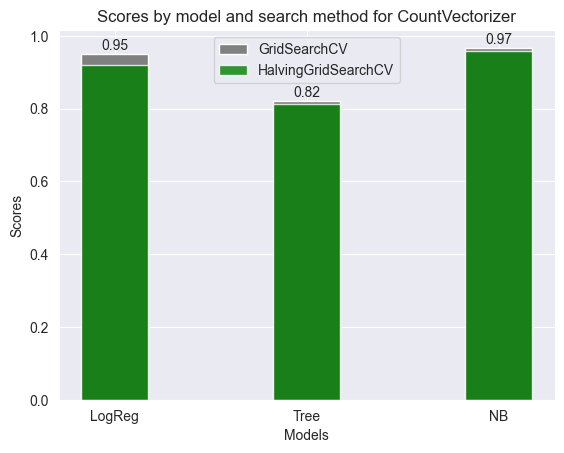

In [160]:
models = ['LogReg', 'Tree', 'NB']
data_pred = [score_log_reg, score_tree, score_nb]
data_pred_h = [score_log_reg_h, score_tree_h, score_nb_h]

df = pd.DataFrame({'model': models, 'GridSearchCV': data_pred, 'HalvingGridSearchCV': data_pred_h})
fig, ax = plt.subplots()
bar_width = 0.35

GridSearchCV_diagram = ax.bar(df['model'], df['GridSearchCV'], bar_width, label='GridSearchCV', color='grey')
HalvingGridSearchCV_diagram = ax.bar(df['model'], df['HalvingGridSearchCV'], bar_width, label='HalvingGridSearchCV',
                                     color='green', alpha=0.8)
max_val = max(data_pred)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by model and search method for CountVectorizer')
ax.legend()
for i, rect in enumerate(GridSearchCV_diagram):
    height = rect.get_height()

    ax.annotate('{}'.format(round(height, 2)),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center')
plt.show()

# TfidfVectorizer
В данном разделе получим вектора при помощи TfidfVectorizer и аналогично обучим модели.

### LogisticRegression:

In [161]:
pipe_log_reg_tfidf = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
)
param_grid_log_reg_tfidf = {
    'tfidf__max_df': np.linspace(0.3, 0.7, 10),
    'tfidf__min_df': [0.0, 0.001, 0.003, 0.005],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': np.linspace(0.1, 1, 10),
}
grid_search_log_reg_tfidf = GridSearchCV(
    pipe_log_reg_tfidf,
    param_grid=param_grid_log_reg_tfidf,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
).fit(x_train, y_train)


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [162]:
grid_search_log_reg_tfidf.best_score_

0.8163508771929824

In [163]:
pred_log_reg_tfidf = grid_search_log_reg_tfidf.predict(x_test)
print(classification_report(y_test, pred_log_reg_tfidf))
score_log_reg_tfidf = grid_search_log_reg_tfidf.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       627
           1       1.00      0.85      0.92       123

    accuracy                           0.98       750
   macro avg       0.99      0.93      0.95       750
weighted avg       0.98      0.98      0.98       750


In [164]:
%%time
grid_search_log_reg_tfidf_h = HalvingGridSearchCV(
    pipe_log_reg_tfidf,
    param_grid=param_grid_log_reg_tfidf,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
    random_state=random_state
)
grid_search_log_reg_tfidf_h.fit(x_train, y_train)

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1200
n_resources: 20
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
----------
iter: 1
n_candidates: 400
n_resources: 60
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 2
n_candidates: 134
n_resources: 180
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 3
n_candidates: 45
n_resources: 540
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 4
n_candidates: 15
n_resources: 1620
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 7 s
Wall time: 18.2 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=20,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'tfidf__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'tfidf__min_df': [0.0, 0.001, 0.003, 0.005],
                                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                    random_state=42, scoring='recall', verbose=1)

In [165]:
grid_search_log_reg_tfidf_h.best_score_

0.7476709421569538

In [166]:
pred_log_reg_tfidf_h = grid_search_log_reg_tfidf_h.predict(x_test)
print(classification_report(y_test, pred_log_reg_tfidf_h))
score_log_reg_tfidf_h = grid_search_log_reg_tfidf_h.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       627
           1       1.00      0.85      0.92       123

    accuracy                           0.98       750
   macro avg       0.99      0.93      0.95       750
weighted avg       0.98      0.98      0.98       750


### DecisionTreeClassifier:

In [167]:
pipe_tree_tfidf = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', DecisionTreeClassifier())
    ]
)
param_grid_tree_tfidf = {
    'tfidf__max_df': np.linspace(0.3, 0.7, 10),
    'tfidf__min_df': [0.0, 0.001, 0.003, 0.005],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__max_depth': [4, 6, 8],
    'clf__min_samples_split': [2, 6, 10, 14, 18],
    'clf__min_samples_leaf': [2, 6, 10, 14, 18],
}

In [194]:
grid_search_tree_tfidf = GridSearchCV(
    pipe_tree_tfidf,
    param_grid=param_grid_tree_tfidf,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
).fit(x_train, y_train)

Fitting 5 folds for each of 9000 candidates, totalling 45000 fits


In [195]:
grid_search_tree_tfidf.best_score_

0.8510526315789473

In [196]:
pred_tree_tfidf = grid_search_tree_tfidf.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_tree_tfidf))
modelTree_tfidf = grid_search_tree_tfidf
score_tree_tfidf = grid_search_tree_tfidf.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       627
           1       0.89      0.82      0.86       123

    accuracy                           0.95       750
   macro avg       0.93      0.90      0.91       750
weighted avg       0.95      0.95      0.95       750


In [199]:
with open('modelTree_tfidf.pkl', 'wb') as f:
    cloudpickle.dump(modelTree_tfidf, f)

In [188]:
with open('modelTree_tfidf.pkl', 'rb') as f:
    modelTree_tfidf = cloudpickle.load(f)
score_tree_tfidf = modelTree_tfidf.score(x_test, y_test)

In [200]:
%%time

grid_search_tree_tfidf_h = HalvingGridSearchCV(
    pipe_tree_tfidf,
    param_grid=param_grid_tree_tfidf,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
    random_state=random_state,
)
grid_search_tree_tfidf_h.fit(x_train, y_train)

n_iterations: 5
n_required_iterations: 9
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9000
n_resources: 20
Fitting 5 folds for each of 9000 candidates, totalling 45000 fits
----------
iter: 1
n_candidates: 3000
n_resources: 60
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
----------
iter: 2
n_candidates: 1000
n_resources: 180
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
----------
iter: 3
n_candidates: 334
n_resources: 540
Fitting 5 folds for each of 334 candidates, totalling 1670 fits
----------
iter: 4
n_candidates: 112
n_resources: 1620
Fitting 5 folds for each of 112 candidates, totalling 560 fits
CPU times: total: 54.6 s
Wall time: 2min 33s


HalvingGridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=20,
                    param_grid={'clf__max_depth': [4, 6, 8],
                                'clf__min_samples_leaf': [2, 6, 10, 14, 18],
                                'clf__min_samples_split': [2, 6, 10, 14, 18],
                                'tfidf__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'tfidf__min_df': [0.0, 0.001, 0.003, 0.005],
                                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                    random_state=42, scoring='recall', verbose=1)

In [201]:
grid_search_tree_tfidf_h.best_score_

0.8372827400316014

In [202]:
pred_tree_tfidf_h = grid_search_tree_tfidf_h.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_tree_tfidf_h))
score_tree_tfidf_h = grid_search_tree_tfidf_h.score(x_test, y_test)
print(score_tree_tfidf_h, score_tree_tfidf)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       627
           1       0.82      0.83      0.82       123

    accuracy                           0.94       750
   macro avg       0.89      0.90      0.89       750
weighted avg       0.94      0.94      0.94       750

0.8292682926829268 0.8211382113821138


### MultinomialNB:

In [175]:
pipe_nb_tfidf = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ]
)
param_grid_nb_tfidf = {
    'tfidf__max_df': np.linspace(0.3, 0.7, 10),
    'tfidf__min_df': [0.0, 0.001, 0.003, 0.005],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': [0.001, 0.1, 1],
}
grid_search_nb_tfidf = GridSearchCV(
    pipe_nb_tfidf,
    param_grid=param_grid_nb_tfidf,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
).fit(x_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [176]:
grid_search_nb_tfidf.best_score_

0.9547719298245614

In [177]:
pred_nb_tfidf = grid_search_nb_tfidf.predict(x_test)
print(classification_report(y_test, pred_nb_tfidf))
score_nb_tfidf = grid_search_nb_tfidf.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       627
           1       1.00      0.96      0.98       123

    accuracy                           0.99       750
   macro avg       1.00      0.98      0.99       750
weighted avg       0.99      0.99      0.99       750


In [178]:
%%time
grid_search_nb_tfidf_h = HalvingGridSearchCV(
    pipe_nb_tfidf,
    param_grid=param_grid_nb_tfidf,
    n_jobs=20,
    verbose=1,
    cv=cv,
    scoring=metric,
    random_state=random_state
)
grid_search_nb_tfidf_h.fit(x_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2249
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 360
n_resources: 20
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 120
n_resources: 60
Fitting 5 folds for each of 120 candidates, totalling 600 fits
----------
iter: 2
n_candidates: 40
n_resources: 180
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 3
n_candidates: 14
n_resources: 540
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 4
n_candidates: 5
n_resources: 1620
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 3.52 s
Wall time: 6.06 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=20,
                    param_grid={'clf__alpha': [0.001, 0.1, 1],
                                'tfidf__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'tfidf__min_df': [0.0, 0.001, 0.003, 0.005],
                                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
                    random_state=42, scoring='recall', verbose=1)

In [179]:
grid_search_nb_tfidf_h.best_score_

0.9208879387799362

In [180]:
pred_nb_tfidf_h = grid_search_nb_tfidf_h.best_estimator_.predict(x_test)
print(classification_report(y_test, pred_nb_tfidf_h))
score_nb_tfidf_h = grid_search_nb_tfidf_h.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       627
           1       1.00      0.96      0.98       123

    accuracy                           0.99       750
   macro avg       1.00      0.98      0.99       750
weighted avg       0.99      0.99      0.99       750


## Подведение итогов по TfidfVectorizer
Аналогичным образом был построен график для TfidfVectorizer. HalvingGridSearchCV и GridSearchCV тут справились для двух моделей одинаково. По какой-то причине HalvingGridSearchCV нашел для модели "Дерево решений" параметры лучше, чем GridSearchCV, который делает полный перебор (что очень странно). Лучший score был достигнут для модели Naive Bayes.

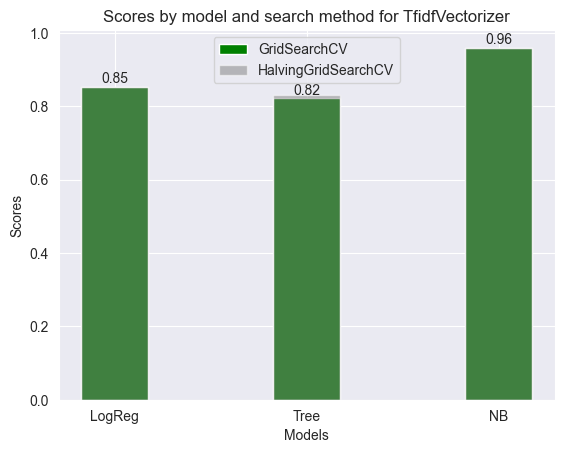

In [225]:
models = ['LogReg', 'Tree', 'NB']
data_pred_tfidf = [score_log_reg_tfidf, score_tree_tfidf, score_nb_tfidf]
data_pred_tfidf_h = [score_log_reg_tfidf_h, score_tree_tfidf_h, score_nb_tfidf_h]

df_tfidf = pd.DataFrame({'model': models, 'GridSearchCV': data_pred_tfidf, 'HalvingGridSearchCV': data_pred_tfidf_h})
fig, ax = plt.subplots()
bar_width = 0.35

GridSearchCV_diagram = ax.bar(df_tfidf['model'], df_tfidf['GridSearchCV'], bar_width, label='GridSearchCV', color='green')
HalvingGridSearchCV_diagram = ax.bar(df_tfidf['model'], df_tfidf['HalvingGridSearchCV'], bar_width, label='HalvingGridSearchCV',
                                     color='grey', alpha=0.5)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by model and search method for TfidfVectorizer')
ax.legend(loc = 'upper center')
for i, rect in enumerate(GridSearchCV_diagram):
    height = rect.get_height()

    ax.annotate('{}'.format(round(height, 2)),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center')
plt.show()

# Сравнение результатов по CountVectorizer и TfidfVectorizer
Как видно из графика ниже, CountVectorizer показал себя лучше, чем TfidfVectorizer. Сравнения были проделаны по score, который был взят у лучшей модели. Лучшая модель - результат GridSearchCV. Наивысший score был достигнут на модели Naive Bayes как для CountVectorizer, так и для TfidfVectorizer.

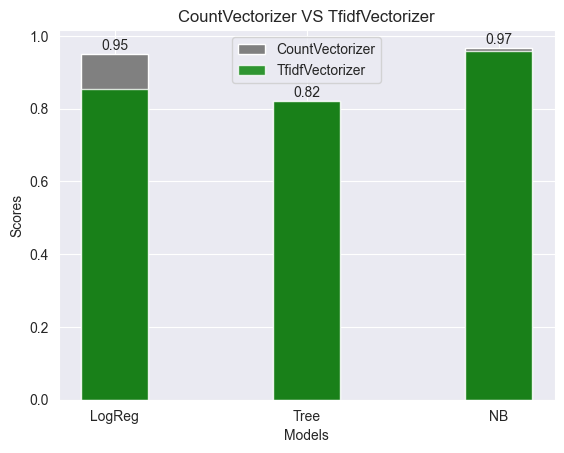

In [228]:
models = ['LogReg', 'Tree', 'NB']
df_compare = pd.DataFrame({'model': models, 'CountVectorizer': data_pred, 'TfidfVectorizer': data_pred_tfidf})
fig, ax = plt.subplots()
bar_width = 0.35

CountVectorizer_diagram = ax.bar(df_compare['model'], df_compare['CountVectorizer'], bar_width, label='CountVectorizer', color='grey')
TfidfVectorizer_diagram = ax.bar(df_compare['model'], df_compare['TfidfVectorizer'], bar_width, label='TfidfVectorizer',
                                     color='green', alpha=0.8)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('CountVectorizer VS TfidfVectorizer')
ax.legend(loc = 'upper center')
for i, rect in enumerate(CountVectorizer_diagram):
    height = rect.get_height()

    ax.annotate('{}'.format(round(height, 2)),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center')
plt.show()